## WCF Modelling

This code:

- Import a CSV and create a random forest model
- Choose a location and download some satellite data
- Apply model to satellite image
- Do some plotting

#### Import modules

In [1]:
%matplotlib inline

import sys
import pandas as pd
import datacube
import matplotlib.pyplot as plt

sys.path.append("../Scripts")
from datacube.helpers import write_geotiff
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_plotting import display_map
from dea_plotting import rgb
from dea_classificationtools import predict_xr
from dea_classificationtools import sklearn_unflatten
from dea_classificationtools import sklearn_flatten
from datacube_stats.statistics import GeoMedian
from dea_bandindices import calculate_indices

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn import metrics

import numpy as np
import xarray as xr
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
dc = datacube.Datacube(app='WCF')

#### Import training data csv

In [3]:
path = 'WCF_traindata_14122019.csv'
df = pd.read_csv(path)
df.head()

,WCF,blue,green,red,nir,swir1,swir2
0,0.680150,0.024840,0.038088,0.041936,0.20717,0.11010,0.062355
1,0.408790,0.043154,0.063489,0.069489,0.22708,0.17888,0.115670
2,0.000004,0.034636,0.064774,0.063311,0.32425,0.21022,0.111040
3,0.216960,0.032932,0.046541,0.050958,0.18029,0.17601,0.108140
4,0.434480,0.030078,0.046560,0.047636,0.20356,0.12678,0.073669


#### Create and evaluate model

https://www.youtube.com/watch?v=YYjvkSJoui4 

Training data formatting

In [4]:
# Handle misisng data
df = df.dropna()

# Define dependent variable
Y = df['WCF']

# Define independent variables
X = df.drop(labels=['WCF'],axis=1)

# Split model into testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

Make a model

In [5]:
# Define model
model = RandomForestRegressor(n_estimators=100, # number of trees in forest, is this equal to ensemble?
                              #criterion = 'mse', # function to measure the quality of the split
                              #max_depth = None, # max depth of tree. If None, then nodes are expanded until all laves are pure, or until all leaves contain less than min_samples_split
                              min_samples_split = 2, # Min no. samples required to be at a split node 
                              min_samples_leaf = 50, # Min no. samples required to be at a leaf node 
                              #min_weight_fraction_leaf = 0, # The min weighted fraction. Samples have equal weight when 0.
                              #max_features = 'auto', # The number of features to consider when looking for the best split
                              #max_leaf_nodes = None, # If None, then unlimited number of leaf nodes
                              #min_impurity_decrease = 0, # Split nodes to decrease impurity
                              #min_impurity_split = 1e-7, # Replaced by min_impurity_decrease
                              #bootstrap = true, # Whether to bootstrap samples when building trees. If False, the whole dataset is used ot build each tree.
                              #oob_score = False, # Whether to use out-of-bag samples to estimate R^2 on unseen data
                              #n_jobs = None, # The number of jobs to run in parallel. None means 1
                              random_state=30, # Controls the randomness of bootstrapping and the sampling of features to consider for bets node split
                              #verbose = 0, # Controls the verbosity when fititng and predicting
                              #warm_start = False, # False - fit new forest, True - reuse solution from previous call amd add more estimators to ensemble
                              #ccp_alpha = 0.0, # Complexity parameter
                              #max_samples = None, # If bootstrap is True, the numbe rof samples to draw from X to train each base estimator
                             )

# Fit model
model.fit(X_train,Y_train)

# Predict test data
prediction_test = model.predict(X_test)

#### Performance metrics

In draft:
- Root mean square estimate (RMSE) = 0.061
- Coefficient of determination (R^2) = 0.862
- Nash-Sutcliffe model efficiency (ME) = 0.862

In [6]:
# Metrics
print('Explained variance score = ')
print(metrics.explained_variance_score(Y_test, prediction_test)) # what measure to use https://scikit-learn.org/stable/modules/model_evaluation.html
print('R^2 =')
print(metrics.r2_score(Y_test, prediction_test))
print('RMSE =')
print(metrics.mean_squared_error(Y_test, prediction_test))

Explained variance score = 
0.9246561500356675
R^2 =
0.9246331026823922
RMSE =
0.0062849142408366344


#### Do some pickling

In [7]:
# # Pickle this model
# pickle_out = open('pickled.pickle','wb')
# pickle.dump(model,pickle_out)
# pickle_out.close()

In [8]:
# pickle_in = open('pickled.pickle','rb')
# improved_grid_model = pickle.load(pickle_in)
# print(improved_grid_model)

## Apply the model to an image

### Choose location

Use custom area of interest:

In [9]:
# location = 'Canberra'

# # Set the central latitude and longitude
# central_lat = -35.434967
# central_lon = 149.002428

# # Set the buffer to load around the central coordinates
# buffer = 0.1

# # Compute the bounding box for the study area
# study_area_lat = (central_lat - buffer, central_lat + buffer)
# study_area_lon = (central_lon - buffer, central_lon + buffer)

# display_map(x=study_area_lon, y=study_area_lat, margin=-0.2)

Use LCCS test areas:

In [ ]:
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

location = 'Murray Valley'
min_x = 1100000
max_x = 1200000
min_y = -4000000
max_y = -3900000

In [34]:
# Make sure to change the location for in the save file
location = 'Kakadu'
min_x = 0
max_x = 100000
min_y = -1350000
max_y = -1250000

x = (min_x, max_x)
y = (min_y, max_y)

res_x = 100
res_y = -100

# Display an interactive map
display_map(x=x, y=y, crs='EPSG:3577', margin=-0.1) 

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


### Load in image collection

In [35]:
start_date = '2010'
end_date = '2015' 

#Load all data in baseline period available from Near Real Time data

i_col = dc.load(
              product=['ls8_nbart_geomedian_annual', 'ls5_nbart_geomedian_annual'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

In [36]:
wofs_col = dc.load(
              product=['wofs_annual_summary'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

In [40]:
fc_col = dc.load(
              product=['ls5_fc_albers','ls8_fc_albers'],
              x=x, #study_area_lon or x
              y=y, #study_area_lat or y
              time=(start_date, end_date),
              #measurements=['nbar_blue','nbar_green','nbar_red','nbar_nir_1', 'nbar_swir_3'],
              output_crs='EPSG:3577',
              crs='EPSG:3577',
              resolution=(res_x,res_y)
              #resolution=(-50, 50),
              #group_by='solar_day'
)

In [41]:
fc_2010 = fc_col.sel(time='2010')#.median(dim='time')
fc_2015 = fc_col.sel(time='2015')#.median(dim='time')
fc_2010

<xarray.Dataset>
Dimensions:  (time: 34, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-14T01:07:24 ... 2010-12-16T01:06:51.500000
  * y        (y) float64 -1.35e+06 -1.35e+06 -1.35e+06 ... -1.25e+06 -1.25e+06
  * x        (x) float64 9.995e+04 9.985e+04 9.975e+04 ... 250.0 150.0 50.0
Data variables:
    BS       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    PV       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    NPV      (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
    UE       (time, y, x) int16 -1 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1 -1
Attributes:
    crs:      EPSG:3577

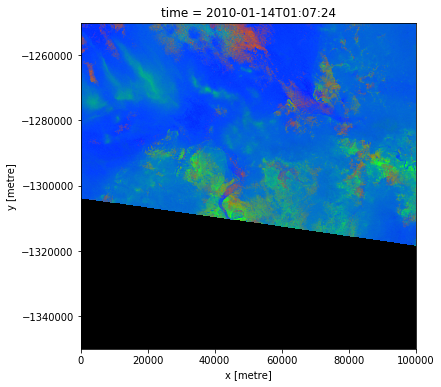

In [42]:
rgb(fc_2010.isel(time=0), bands=['BS', 'PV', 'NPV'])

In [15]:
wofs_2010 = wofs_col.sel(time='2010')
wofs_2015 = wofs_col.sel(time='2015')
wofs_2010

<xarray.Dataset>
Dimensions:      (time: 1, x: 1000, y: 1000)
Coordinates:
  * time         (time) datetime64[ns] 2010-01-01
  * y            (y) float64 -4e+06 -4e+06 -4e+06 ... -3.9e+06 -3.9e+06 -3.9e+06
  * x            (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.1e+06 1.1e+06 1.1e+06
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 2 2 2 3 3 3
    count_clear  (time, y, x) int16 25 25 26 25 25 25 26 ... 30 29 30 31 30 31
    frequency    (time, y, x) float32 0.0 0.0 0.0 ... 0.09677419 0.1 0.09677419
Attributes:
    crs:      EPSG:3577

Select images

<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01
  * y        (y) float64 -4e+06 -4e+06 -4e+06 ... -3.9e+06 -3.9e+06 -3.9e+06
  * x        (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.1e+06 1.1e+06 1.1e+06
Data variables:
    blue     (time, y, x) int16 494 392 440 501 427 476 ... 645 638 590 553 564
    green    (time, y, x) int16 869 742 800 882 804 ... 1020 1022 926 874 882
    red      (time, y, x) int16 1027 743 854 1025 854 ... 1163 1118 1041 980 965
    nir      (time, y, x) int16 2674 2876 2985 2888 3087 ... 2577 2493 2494 2472
    swir1    (time, y, x) int16 3097 2543 2738 3168 2628 ... 2668 2491 2426 2414
    swir2    (time, y, x) int16 2138 1480 1626 2006 1534 ... 1947 1751 1657 1664
Attributes:
    crs:      EPSG:3577
<xarray.Dataset>
Dimensions:  (time: 1, x: 1000, y: 1000)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01
  * y        (y) float64 -4e+06 -4e+06 -4e+06 ... -3.9e+06 -3.9e+06 -3.9e+06
 

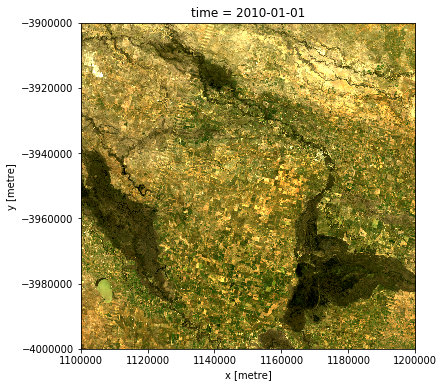

In [16]:
i_2010 = i_col.sel(time='2010')
i_2015 = i_col.sel(time='2015')
print(i_2010)
print(i_2015)
rgb(i_2010, bands=['red','green','blue'])

### Predict WCF on image

Define a function to format image and run model over it

In [17]:
def predict_wcf(image,model):
    flat = sklearn_flatten(image)
    flat = flat/10000
    results = model.predict(flat)
    print('Results:',results)
    unflat = (sklearn_unflatten(results,image).transpose())[0]
    return unflat

In [18]:
wcf_2010 = predict_wcf(i_2010,model)
wcf_2015 = predict_wcf(i_2015,model)

Results: [0.01207244 0.01896172 0.00684603 ... 0.11096154 0.14225565 0.10779824]
Results: [0.04406975 0.02348901 0.06328619 ... 0.2342092  0.16453795 0.10716444]


In [19]:
# NBR
nbr_2010 = (i_2010.nir - i_2010.swir2) / (i_2010.nir + i_2010.swir2)
nbr_2015 = (i_2015.nir - i_2015.swir2) / (i_2015.nir + i_2015.swir2)

In [20]:
#list(dc.list_products()['name'])

### Plot the results

Woody cover in training data varies between 0 and 1

In [27]:
fc_2010.median(dim='time')

<xarray.Dataset>
Dimensions:  (x: 1000, y: 1000)
Coordinates:
  * y        (y) float64 -4e+06 -4e+06 -4e+06 ... -3.9e+06 -3.9e+06 -3.9e+06
  * x        (x) float64 1.2e+06 1.2e+06 1.2e+06 ... 1.1e+06 1.1e+06 1.1e+06
Data variables:
    BS       (y, x) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 3.0 0.0 0.0 0.5 2.0
    PV       (y, x) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 10.5 10.0 11.0 11.5
    NPV      (y, x) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 6.5 3.0 11.0 3.0 1.0
    UE       (y, x) float64 -1.0 -1.0 -1.0 -1.0 -1.0 ... 3.0 3.0 3.0 3.0 3.5

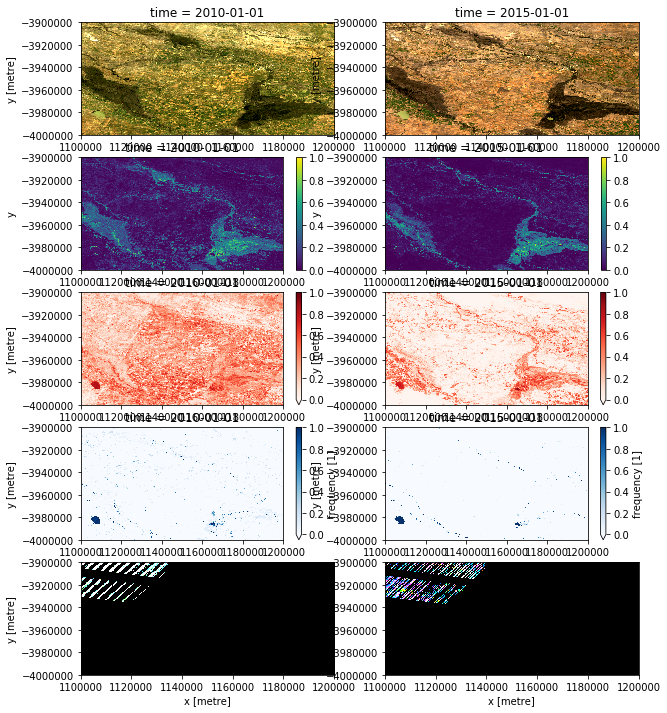

In [29]:
# Set up subplots
f, ax = plt.subplots(5, 2, figsize=(10,12), squeeze=False)

# before images
rgb(i_2010, bands=['red', 'green', 'blue'], ax=ax[0,0])
wcf_2010.plot(ax=ax[1,0],vmin=0,vmax=1)
nbr_2010.plot(ax=ax[2,0],vmin=0,vmax=1,cmap='Reds')
wofs_2010['frequency'].plot(ax=ax[3,0],vmin=0,vmax=1,cmap='Blues')
rgb(fc_2010,ax=ax[4,0], bands=['BS', 'PV', 'NPV'])

# after images
rgb(i_2015, bands=['red', 'green', 'blue'], ax=ax[0,1])
wcf_2015.plot(ax=ax[1,1],vmin=0,vmax=1)
nbr_2015.plot(ax=ax[2,1],vmin=0,vmax=1,cmap='Reds')
wofs_2015['frequency'].plot(ax=ax[3,1],vmin=0,vmax=1,cmap='Blues')
rgb(fc_2015, ax=ax[4,1], bands=['BS', 'PV', 'NPV'])


### Save results to Geotiff
To save results to geotiff for use and analysis in GIS software packages un comment the following Write_geotiff comands.

In [ ]:
# 2010
wcf_2010_ds = wcf_2010.to_dataset(name='wcf_2010').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff(location+'_wcf_2010.tif', wcf_2010_ds)

# 2015
wcf_2015_ds = wcf_2015.to_dataset(name='wcf_2015').assign_attrs({'crs': 'EPSG:3577'})
write_geotiff(location+'_wcf_2015.tif', wcf_2015_ds)

In [ ]:
# NBR
# 2010
nbr_2010_ds = nbr_2010.isel(time=0).to_dataset(name='nbr_2010')
write_geotiff(location+'_nbr_2010.tif', nbr_2010_ds)

# 2015
nbr_2015_ds = nbr_2015.isel(time=0).to_dataset(name='nbr_2015')
write_geotiff(location+'_nbr_2015.tif', nbr_2015_ds)

In [ ]:
# Frequency
# 2010
wofs_2010_ds = wofs_2010['frequency'].isel(time=0).to_dataset(name='wofs_2010')
write_geotiff(location+'_wofs_2010.tif', wofs_2010_ds)

# 2015
wofs_2015_ds = wofs_2015['frequency'].isel(time=0).to_dataset(name='wofs_2015')
write_geotiff(location+'_wofs_2015.tif', wofs_2015_ds)

In [ ]:
# Fractional Cover
# 2010
fc_2010_ds = fc_2010['frequency'].isel(time=0).to_dataset(name='fc_2010')
write_geotiff(location+'_fc_2010.tif', fc_2010_ds)

# 2015
fc_2015_ds = fc_2015['frequency'].isel(time=0).to_dataset(name='fc_2015')
write_geotiff(location+'_fc_2015.tif', fc_2015_ds)